# Using Uproot effectively

## How this works as a hands-on tutorial

Even though I don't have formal exercises scattered throughout these notebooks, this session can still be interactive.

   * **You** should open each notebook in Binder (see [GitHub README](https://github.com/jpivarski/2020-06-08-uproot-awkward-columnar-hats)) and evaluate cells, following along with me.
   * **I** should pause frequently and stay open to questions. I'll be monitoring the videoconference chat.
   * **We** should feel free to step off the path and try to answer "What if?" questions in real time.

Not all digressions will lead to an answer—I often realize, "That's why it didn't work!" long after the tutorial is over—but tinkering is how we learn.

Consider this a tour and I'm your guide. The planned route is a suggestion to get things started, but your questions are more important.

(Also, I'm awful at writing formal exercises; they end up being too easy _and_ too hard.)

<br><br><br>

## Increasingly unnecessary introduction to/motivation for Python

I used to start these tutorials by asking, "Why Python?" but that doesn't seem necessary anymore.

![](img/python-usage.png)

<br><br><br>

## What is Uproot?

![](img/abstraction-layers.png)

Uproot is an independent implementation of ROOT I/O and only I/O, using standard Python libraries wherever possible.

<br><br><br>

It's fairly popular, at least among _Python_ packages for _particle physics_.

![](img/awkward-0-popularity.png)

(Apologies to Coffea members: it would be very interesting to reload this analysis with 2020 data!)

<br><br><br>

## Why was Uproot written?

![](img/uproot-awkward-timeline.png)

Uproot was originally a part of Femtocode, a query language for calculations on columnar data. I needed an easier way to deploy ROOT I/O.

   * **Uproot 1.x** was released as a Python package "in case anyone finds it useful."
   * Machine learning users did find it useful, so I quickly cleaned it up and made it presentable as **Uproot 2.x**.
   * The way people were using Uproot influenced how I thought about columnar analysis: breaking it out into smaller pieces and eventually the exposing array-at-a-time interface to users, rather than hiding the columnar processing behind a query language.
   * Uproot's "bottom up" JaggedArrays were moved into a new package, **Awkward Array**, replacing the "top down" view of OAMap. This was **Uproot 3.x**.
   * Awkward Array is successful even though it has interface flaws and its pure Python "no for loops!" implementation is hard to maintain.
   * **Awkward 1.x** started last fall with a long development time to "do it right." It is complete, but not very visible because Uproot doesn't produce the new-style arrays yet.
   * **Uproot 4.x** started development in May with a release date of July 1.

Unlike previous version updates (which were more minor), Uproot 3.x and Awkward 0.x will continue to exist as `uproot3` and `awkward0`.

<br><br><br>

Sometime this summer, `uproot4` → `uproot` and `awkward1` → `awkward`. If you need to keep old scripts working, you'll be able to

```python
import uproot3 as uproot
import awkward0 as awkward
```

but new work should use the new libraries. (The old ones will continue to exist, though won't be actively maintained.)

![](img/Raiders-of-the-Lost-Ark-Chamber.jpg)

<br><br><br>

## Opening a file with Uproot

The read-only interface starts with `uproot.open`.

In [1]:
import uproot

file = uproot.open("data/nesteddirs.root")
file

<ROOTDirectory b'tests/nesteddirs.root' at 0x7f0e003e9950>

A file has a dict-like interface, meaning that you can access objects with square brackets and list them with `keys`.

In [2]:
file.keys()

[b'one;1', b'three;1']

In [3]:
file["one"]

<ROOTDirectory b'one' at 0x7f0e003e87d0>

In [4]:
file["one"].keys()

[b'two;1', b'tree;1']

In [5]:
file.allkeys()

[b'one;1',
 b'one/two;1',
 b'one/two/tree;1',
 b'one/tree;1',
 b'three;1',
 b'three/tree;1']

In [6]:
file.allclassnames()

[(b'one;1', 'TDirectory'),
 (b'one/two;1', 'TDirectory'),
 (b'one/two/tree;1', 'TTree'),
 (b'one/tree;1', 'TTree'),
 (b'three;1', 'TDirectory'),
 (b'three/tree;1', 'TTree')]

### What's the `b` at the beginning of each file path?

These are bytestrings, not strings, and Python 3 emphasizes the difference.

I was worried that old ROOT files would use strange encodings and thought that presuming everything to be UTF-8 would make hist�gr�m title� l��k like th�s.

But the issue of encodings never came up. Dealing with the Python bytestrings has been more of a nuisance.

### Technology preview: Uproot 4

Uproot 4 is only half-written and might fail in simple cases. However, we can try it out side-by-side with Uproot 3 because it has a different package name.

In [7]:
import uproot4

file_uproot4 = uproot4.open("data/nesteddirs.root")
file_uproot4

<ReadOnlyDirectory '/' at 0x7f0e002f3b10>

In [8]:
# recursive=True is now the default; there's no 'allkeys'
file_uproot4.keys()

['one;1',
 'one/two;1',
 'one/two/tree;1',
 'one/tree;1',
 'three;1',
 'three/tree;1']

In [9]:
# now a dict, and no bytestrings
file_uproot4.classnames()

{'one': 'TDirectory',
 'one/two': 'TDirectory',
 'one/two/tree': 'TTree',
 'one/tree': 'TTree',
 'three': 'TDirectory',
 'three/tree': 'TTree'}

In [10]:
file_uproot4.classname_of("one/two/tree")

'TTree'

In [11]:
file_uproot4.classname_of("one/two/tree;1")

'TTree'

No more bytestrings. (Invalid UTF-8 uses the "surrogate escape" method, so a strangely encoded string won't _break_ anything, at least.)

### What's the `;1` at the end of the key name?

These are ROOT "cycle numbers," which allow objects with the same name to exist in the same directory. We display them to disambiguate, but you don't have to type them to look up an object. (You'll get the latest one; the one with the highest cycle.)

## Exploring a TTree

TTrees also have a dict-like interface, though the `show` method has been very useful.

In [12]:
tree = file["one/two/tree"]
tree

<TTree b'tree' at 0x7f0e002a0b90>

In [13]:
tree.keys()

[b'Int32',
 b'Int64',
 b'UInt32',
 b'UInt64',
 b'Float32',
 b'Float64',
 b'Str',
 b'ArrayInt32',
 b'ArrayInt64',
 b'ArrayUInt32',
 b'ArrayUInt64',
 b'ArrayFloat32',
 b'ArrayFloat64',
 b'N',
 b'SliceInt32',
 b'SliceInt64',
 b'SliceUInt32',
 b'SliceUInt64',
 b'SliceFloat32',
 b'SliceFloat64']

In [14]:
tree.show()

Int32                      (no streamer)              asdtype('>i4')
Int64                      (no streamer)              asdtype('>i8')
UInt32                     (no streamer)              asdtype('>u4')
UInt64                     (no streamer)              asdtype('>u8')
Float32                    (no streamer)              asdtype('>f4')
Float64                    (no streamer)              asdtype('>f8')
Str                        (no streamer)              asstring()
ArrayInt32                 (no streamer)              asdtype("('>i4', (10,))")
ArrayInt64                 (no streamer)              asdtype("('>i8', (10,))")
ArrayUInt32                (no streamer)              asdtype("('>u4', (10,))")
ArrayUInt64                (no streamer)              asdtype("('>u8', (10,))")
ArrayFloat32               (no streamer)              asdtype("('>f4', (10,))")
ArrayFloat64               (no streamer)              asdtype("('>f8', (10,))")
N                          (no streamer) 

Left column: branch names, middle column: streamers (which define complex types), right column: how _we_ interpret the branch as an array (Uproot-specific).

In [15]:
tree["Float64"].array()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [16]:
tree["ArrayInt32"].array()

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
       [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
       [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
       [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
       [14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
       [15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
       [16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
       [17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
       [18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
       [19, 19, 19, 19, 19, 19, 19, 19, 19, 19],
       [20, 20, 20, 

In [17]:
tree["SliceInt64"].array()

<JaggedArray [[] [1] [2 2] ... [97 97 97 ... 97 97 97] [98 98 98 ... 98 98 98] [99 99 99 ... 99 99 99]] at 0x7f0e002c0910>

The last of these is a jagged array, which has a variable number of items in each entry.

   * Uproot 3 returns NumPy arrays for scalar and fixed-length per entry types.
   * Uproot 3 returns Awkward 0 JaggedArrays for variable-length per entry types.
   * Uproot 4 (by default) returns Awkward 1 arrays for all branches.

In [18]:
file_uproot4["one/two/tree/Float64"].array()

<Array [0, 1, 2, 3, 4, ... 95, 96, 97, 98, 99] type='100 * float64'>

In [19]:
file_uproot4["one/two/tree/ArrayInt32"].array()

<Array [[0, 0, 0, 0, 0, ... 99, 99, 99, 99]] type='100 * 10 * int32'>

In [20]:
file_uproot4["one/two/tree/SliceInt64"].array()

<Array [[], [1], [2, ... 99, 99, 99, 99, 99]] type='100 * var * int64'>

It's still possible to get NumPy arrays with `library="np"` (i.e. return type depends on what you ask for, not the contents of the file).

In [21]:
file_uproot4["one/two/tree/Float64"].array(library="np")

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [22]:
file_uproot4["one/two/tree/ArrayInt32"].array(library="np")

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
       [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
       [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
       [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
       [14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
       [15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
       [16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
       [17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
       [18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
       [19, 19, 19, 19, 19, 19, 19, 19, 19, 19],
       [20, 20, 20, 

In [23]:
file_uproot4["one/two/tree/SliceInt64"].array(library="np")

array([array([], dtype=int64), array([1]), array([2, 2]),
       array([3, 3, 3]), array([4, 4, 4, 4]), array([5, 5, 5, 5, 5]),
       array([6, 6, 6, 6, 6, 6]), array([7, 7, 7, 7, 7, 7, 7]),
       array([8, 8, 8, 8, 8, 8, 8, 8]),
       array([9, 9, 9, 9, 9, 9, 9, 9, 9]), array([], dtype=int64),
       array([11]), array([12, 12]), array([13, 13, 13]),
       array([14, 14, 14, 14]), array([15, 15, 15, 15, 15]),
       array([16, 16, 16, 16, 16, 16]),
       array([17, 17, 17, 17, 17, 17, 17]),
       array([18, 18, 18, 18, 18, 18, 18, 18]),
       array([19, 19, 19, 19, 19, 19, 19, 19, 19]),
       array([], dtype=int64), array([21]), array([22, 22]),
       array([23, 23, 23]), array([24, 24, 24, 24]),
       array([25, 25, 25, 25, 25]), array([26, 26, 26, 26, 26, 26]),
       array([27, 27, 27, 27, 27, 27, 27]),
       array([28, 28, 28, 28, 28, 28, 28, 28]),
       array([29, 29, 29, 29, 29, 29, 29, 29, 29]),
       array([], dtype=int64), array([31]), array([32, 32]),
       arr

Also, Pandas is a `library`, rather than a special function, as well as CuPy (GPU arrays) and any others we might want to add in the future.

In [24]:
file_uproot4["one/two/tree/SliceInt64"].array(library="pd")

entry  subentry
1      0            1
2      0            2
       1            2
3      0            3
       1            3
                   ..
99     4           99
       5           99
       6           99
       7           99
       8           99
Length: 450, dtype: int64

## How ROOT data are organized

Objects in directories are referenced by TKeys—you can ignore these, as they just make the square brackets syntax work.

A TTree's TBranches are either containers of data, convertible to arrays, or placeholders in a hierarchy describing a "split" object (more on that later).

The actual data are broken up into TBaskets, which is the smallest unit that can be read from a compressed file. There's no such thing as "reading one event," unless you have one TBasket per event (which would be inefficient when reading many events).

![](img/terminology.png)

Often, you can ignore TBaskets: Uproot treats TBranches as the fundamental unit, with one TBranch → one array.

But if your file compresses poorly or is slow to read, check the TBasket sizes to see that they are at least 10's to 100's of kilobytes each.

In [25]:
events = uproot.open("data/cms_opendata_2012_nanoaod_DoubleMuParked.root")["Events"]
events

<TTree b'Events' at 0x7f0d96267e50>

In [26]:
for name in events.keys():
    print(f"{name.decode():20} {events[name].numbaskets:2d} baskets {[events[name].basket_uncompressedbytes(i)/1024 for i in range(events[name].numbaskets)]} kB each")

run                   5 baskets [950.0234375, 950.0234375, 950.0234375, 950.0234375, 106.15625] kB each
luminosityBlock       5 baskets [950.0234375, 950.0234375, 950.0234375, 950.0234375, 106.15625] kB each
event                 5 baskets [1900.046875, 1900.046875, 1900.046875, 1900.046875, 212.3125] kB each
PV_npvs               5 baskets [950.0234375, 950.0234375, 950.0234375, 950.0234375, 106.15625] kB each
PV_x                  5 baskets [950.0234375, 950.0234375, 950.0234375, 950.0234375, 106.15625] kB each
PV_y                  5 baskets [950.0234375, 950.0234375, 950.0234375, 950.0234375, 106.15625] kB each
PV_z                  5 baskets [950.0234375, 950.0234375, 950.0234375, 950.0234375, 106.15625] kB each
nMuon                 5 baskets [950.0234375, 950.0234375, 950.0234375, 950.0234375, 106.15625] kB each
Muon_pt              12 baskets [2486.1875, 709.421875, 1502.57421875, 1502.59375, 193.62890625, 1502.984375, 1502.25, 192.41015625, 1502.4765625, 1502.4140625, 192.5039

This affects ROOT performance, but it affects Uproot performance _more_.

![](img/root-none-muon.png)

(The TFile-TTree-TBranch-TBasket structure has to be navigated in slow Python, but reading/decompressing/interpreting a TBasket is a NumPy call, about as fast as the hardware allows.)

## Split objects

ROOT TTrees are intended to deliver collections of C++ objects. Strictly speaking, these objects have no equivalent in Python—certainly their C++ methods can't be executed by Python. (The C++ code is not stored in the file with the data, even if we had a runtime C++ compiler. That's why some ROOT scripts require `.L` to load libraries.)

What the ROOT files _do_ provide is a list of each class's private member data and how they are laid out in bytes (called the `TStreamerInfo`). We can use that to generate Python classes and reconstruct the objects. However, that has to run in slow Python, not fast NumPy.

As a storage optimization, ROOT files can be written with each member datum in a separate branch. This is called the "splitLevel" and [you can control it when writing files](https://root.cern.ch/doc/master/classTTree.html#addingacolumnofobjs) (if you have access to the process that writes files).

Split data are

   * less likely to contain unsupported features (data structures that Uproot can't read might be in a branch you don't need to read);
   * often faster because they can be read in a single NumPy call, rather than many Python statements;
   * possible to read one column at a time, without touching the others (in ROOT and Uproot).

Let's look at an example of the same data in unsplit and split form:

In [27]:
unsplit = uproot.open("data/small-evnt-tree-nosplit.root")["tree"]
split = uproot.open("data/small-evnt-tree-fullsplit.root")["tree"]

In [28]:
unsplit.show()

evt                        TStreamerInfo              asgenobj(Event)


In [29]:
split.show()

evt                        TStreamerInfo              None
Beg                        TStreamerString            asstring()
I16                        TStreamerBasicType         asdtype('>i2')
I32                        TStreamerBasicType         asdtype('>i4')
I64                        TStreamerBasicType         asdtype('>i8')
U16                        TStreamerBasicType         asdtype('>u2')
U32                        TStreamerBasicType         asdtype('>u4')
U64                        TStreamerBasicType         asdtype('>u8')
F32                        TStreamerBasicType         asdtype('>f4')
F64                        TStreamerBasicType         asdtype('>f8')
Str                        TStreamerString            asstring()
P3                         TStreamerObjectAny         None
P3.Px                      TStreamerBasicType         asdtype('>i4')
P3.Py                      TStreamerBasicType         asdtype('>f8')
P3.Pz                      TStreamerBasicType         asdtype(

We can read the unsplit data, and they are Python objects with attributes.

In [30]:
unsplit_events = unsplit["evt"].array()
unsplit_events

<ObjectArray [<Event at 0x7f0d93277dd0> <Event at 0x7f0d93277cd0> <Event at 0x7f0d93277d10> ... <Event at 0x7f0d93277b10> <Event at 0x7f0d93277c90> <Event at 0x7f0d93277f50>] at 0x7f0d93267c50>

In [37]:
unsplit_events[5]._SliceI64

array([5, 5, 5, 5, 5])

We could ask for all attributes of one event.

In [39]:
{name: getattr(unsplit_events[5], "_" + name) for name in unsplit_events[5]._fields}

{'Beg': b'beg-005',
 'I16': 5,
 'I32': 5,
 'I64': 5,
 'U16': 5,
 'U32': 5,
 'U64': 5,
 'F32': 5.0,
 'F64': 5.0,
 'Str': b'evt-005',
 'P3': <Undefined (failed to read 'P3' version 0) at 0x7f0d9327f210>,
 'ArrayI16': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int16),
 'ArrayI32': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32),
 'ArrayI64': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]),
 'ArrayU16': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=uint16),
 'ArrayU32': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=uint32),
 'ArrayU64': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=uint64),
 'ArrayF32': array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.], dtype=float32),
 'ArrayF64': array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
 'N': 5,
 'SliceI16': array([5, 5, 5, 5, 5], dtype=int16),
 'SliceI32': array([5, 5, 5, 5, 5], dtype=int32),
 'SliceI64': array([5, 5, 5, 5, 5]),
 'SliceU16': array([5, 5, 5, 5, 5], dtype=uint16),
 'SliceU32': array([5, 5, 5, 5, 5], dtype=uint32),
 'SliceU64': array([5, 5, 5, 5,

Or we could ask for the same attribute from all events.

In [31]:
list_of_numpy_arrays = [x._SliceI64 for x in unsplit_events]
list_of_numpy_arrays

[array([], dtype=int64),
 array([1]),
 array([2, 2]),
 array([3, 3, 3]),
 array([4, 4, 4, 4]),
 array([5, 5, 5, 5, 5]),
 array([6, 6, 6, 6, 6, 6]),
 array([7, 7, 7, 7, 7, 7, 7]),
 array([8, 8, 8, 8, 8, 8, 8, 8]),
 array([9, 9, 9, 9, 9, 9, 9, 9, 9]),
 array([], dtype=int64),
 array([11]),
 array([12, 12]),
 array([13, 13, 13]),
 array([14, 14, 14, 14]),
 array([15, 15, 15, 15, 15]),
 array([16, 16, 16, 16, 16, 16]),
 array([17, 17, 17, 17, 17, 17, 17]),
 array([18, 18, 18, 18, 18, 18, 18, 18]),
 array([19, 19, 19, 19, 19, 19, 19, 19, 19]),
 array([], dtype=int64),
 array([21]),
 array([22, 22]),
 array([23, 23, 23]),
 array([24, 24, 24, 24]),
 array([25, 25, 25, 25, 25]),
 array([26, 26, 26, 26, 26, 26]),
 array([27, 27, 27, 27, 27, 27, 27]),
 array([28, 28, 28, 28, 28, 28, 28, 28]),
 array([29, 29, 29, 29, 29, 29, 29, 29, 29]),
 array([], dtype=int64),
 array([31]),
 array([32, 32]),
 array([33, 33, 33]),
 array([34, 34, 34, 34]),
 array([35, 35, 35, 35, 35]),
 array([36, 36, 36, 36, 3

The above approximates what the split file naturally has: a column representing a single field of all events.

In [32]:
jagged_array = split["SliceI64"].array()
jagged_array

<JaggedArray [[] [1] [2 2] ... [97 97 97 ... 97 97 97] [98 98 98 ... 98 98 98] [99 99 99 ... 99 99 99]] at 0x7f0d9689c950>

It looks different because it is different:

   * the Python list comprehension over unsplit objects made a list of NumPy arrays;
   * the split data was directly read into a JaggedArray.

The JaggedArray has features that the list of NumPy arrays doesn't (more on Awkward Array in the second hour).

For instance, you can slice the second dimension, which has variable length.

In [33]:
jagged_array[:, :3]

<JaggedArray [[] [1] [2 2] ... [97 97 97] [98 98 98] [99 99 99]] at 0x7f0d9327fa90>

But not in a Python list of NumPy arrays. Python doesn't think of the objects in the list as being part of the list.

In [34]:
list_of_numpy_arrays[:, :3]

TypeError: list indices must be integers or slices, not tuple

Through a construction, we can build the same kind of objects from unsplit data:

In [41]:
import awkward1 as ak

events = ak.Array([{name: getattr(obj, "_" + name) for name in obj._fields if name != "P3"} for obj in unsplit_events])
events

<Array [{Beg: b'beg-000', ... End: b'end-099'}] type='100 * {"Beg": bytes, "I16"...'>

This is now an array of everything; its type shows the full structure.

In [45]:
ak.type(events)

100 * {"Beg": bytes, "I16": int64, "I32": int64, "I64": int64, "U16": int64, "U32": int64, "U64": int64, "F32": float64, "F64": float64, "Str": bytes, "ArrayI16": var * int64, "ArrayI32": var * int64, "ArrayI64": var * int64, "ArrayU16": var * int64, "ArrayU32": var * int64, "ArrayU64": var * int64, "ArrayF32": var * float64, "ArrayF64": var * float64, "N": int64, "SliceI16": var * int64, "SliceI32": var * int64, "SliceI64": var * int64, "SliceU16": var * int64, "SliceU32": var * int64, "SliceU64": var * int64, "SliceF32": var * float64, "SliceF64": var * float64, "StdStr": bytes, "StlVecI16": var * int64, "StlVecI32": var * int64, "StlVecI64": var * int64, "StlVecU16": var * int64, "StlVecU32": var * int64, "StlVecU64": var * int64, "StlVecF32": var * float64, "StlVecF64": var * float64, "End": bytes}

In [42]:
events.SliceI64

<Array [[], [1], [2, ... 99, 99, 99, 99, 99]] type='100 * var * int64'>

In [43]:
ak.from_awkward0(jagged_array)

<Array [[], [1], [2, ... 99, 99, 99, 99, 99]] type='100 * var * int64'>

In [46]:
ak.from_awkward0(jagged_array) == events.SliceI64

<Array [[], [True], ... True, True, True]] type='100 * var * bool'>

In [47]:
ak.all(ak.from_awkward0(jagged_array) == events.SliceI64)

True

But you shouldn't have to write this manually. Uproot 4 will do that for you (taking advantage of some Awkward 1 features).

## Histograms

Sometimes, though, we want objects to have methods. TTree (also auto-generated from `TStreamerInfo`, like anything else) is a prime example: we want TTrees to have methods that read TBaskets and convert them into arrays.

Uproot has a stable set of "mixin classes," which define methods but no data, as well as the auto-generated "models" that deserialize and store data. Runtime classes inherit from both.

Histograms, for instance, have some analysis methods.

In [48]:
histograms = uproot.open("data/hepdata-example.root")
histograms.classnames()

[(b'hpx;1', 'TH1F'),
 (b'hpxpy;1', 'TH2F'),
 (b'hprof;1', 'TProfile'),
 (b'ntuple;1', 'TNtuple')]

In [49]:
histograms["hpx"].show()

                    0                                                     2537.8
                    +----------------------------------------------------------+
[-inf, -4)     2    |                                                          |
[-4, -3.92)    2    |                                                          |
[-3.92, -3.84) 3    |                                                          |
[-3.84, -3.76) 1    |                                                          |
[-3.76, -3.68) 1    |                                                          |
[-3.68, -3.6)  2    |                                                          |
[-3.6, -3.52)  4    |                                                          |
[-3.52, -3.44) 6    |                                                          |
[-3.44, -3.36) 12   |                                                          |
[-3.36, -3.28) 8    |                                                          |
[-3.28, -3.2)  9    |       

(A shout-out: see [scikit-hep/histoprint](https://github.com/ast0815/histoprint) for a more fully featured package that will take over the job of pretty-printing histograms.)

These methods are convenient ways to access the C++ private members. For instance,

In [73]:
histograms["hpx"]._fTitle

b'This is the px distribution'

In [74]:
histograms["hpx"].title

b'This is the px distribution'

In [75]:
histograms["hpx"]._fXaxis

<TAxis b'xaxis' at 0x7f0d8ba5b050>

In [86]:
histograms["hpx"].bins

array([[-4.  , -3.92],
       [-3.92, -3.84],
       [-3.84, -3.76],
       [-3.76, -3.68],
       [-3.68, -3.6 ],
       [-3.6 , -3.52],
       [-3.52, -3.44],
       [-3.44, -3.36],
       [-3.36, -3.28],
       [-3.28, -3.2 ],
       [-3.2 , -3.12],
       [-3.12, -3.04],
       [-3.04, -2.96],
       [-2.96, -2.88],
       [-2.88, -2.8 ],
       [-2.8 , -2.72],
       [-2.72, -2.64],
       [-2.64, -2.56],
       [-2.56, -2.48],
       [-2.48, -2.4 ],
       [-2.4 , -2.32],
       [-2.32, -2.24],
       [-2.24, -2.16],
       [-2.16, -2.08],
       [-2.08, -2.  ],
       [-2.  , -1.92],
       [-1.92, -1.84],
       [-1.84, -1.76],
       [-1.76, -1.68],
       [-1.68, -1.6 ],
       [-1.6 , -1.52],
       [-1.52, -1.44],
       [-1.44, -1.36],
       [-1.36, -1.28],
       [-1.28, -1.2 ],
       [-1.2 , -1.12],
       [-1.12, -1.04],
       [-1.04, -0.96],
       [-0.96, -0.88],
       [-0.88, -0.8 ],
       [-0.8 , -0.72],
       [-0.72, -0.64],
       [-0.64, -0.56],
       [-0.

In [87]:
histograms["hpx"].edges

array([-4.  , -3.92, -3.84, -3.76, -3.68, -3.6 , -3.52, -3.44, -3.36,
       -3.28, -3.2 , -3.12, -3.04, -2.96, -2.88, -2.8 , -2.72, -2.64,
       -2.56, -2.48, -2.4 , -2.32, -2.24, -2.16, -2.08, -2.  , -1.92,
       -1.84, -1.76, -1.68, -1.6 , -1.52, -1.44, -1.36, -1.28, -1.2 ,
       -1.12, -1.04, -0.96, -0.88, -0.8 , -0.72, -0.64, -0.56, -0.48,
       -0.4 , -0.32, -0.24, -0.16, -0.08,  0.  ,  0.08,  0.16,  0.24,
        0.32,  0.4 ,  0.48,  0.56,  0.64,  0.72,  0.8 ,  0.88,  0.96,
        1.04,  1.12,  1.2 ,  1.28,  1.36,  1.44,  1.52,  1.6 ,  1.68,
        1.76,  1.84,  1.92,  2.  ,  2.08,  2.16,  2.24,  2.32,  2.4 ,
        2.48,  2.56,  2.64,  2.72,  2.8 ,  2.88,  2.96,  3.04,  3.12,
        3.2 ,  3.28,  3.36,  3.44,  3.52,  3.6 ,  3.68,  3.76,  3.84,
        3.92,  4.  ])

In [89]:
print(histograms["hpx"].hepdata())

dependent_variables:
- header:
    name: counts
    units: null
  qualifiers: []
  values:
  - errors:
    - label: stat
      symerror: 1.4142135623730951
    value: 2.0
  - errors:
    - label: stat
      symerror: 1.7320508075688772
    value: 3.0
  - errors:
    - label: stat
      symerror: 1.0
    value: 1.0
  - errors:
    - label: stat
      symerror: 1.0
    value: 1.0
  - errors:
    - label: stat
      symerror: 1.4142135623730951
    value: 2.0
  - errors:
    - label: stat
      symerror: 2.0
    value: 4.0
  - errors:
    - label: stat
      symerror: 2.449489742783178
    value: 6.0
  - errors:
    - label: stat
      symerror: 3.4641016151377544
    value: 12.0
  - errors:
    - label: stat
      symerror: 2.8284271247461903
    value: 8.0
  - errors:
    - label: stat
      symerror: 3.0
    value: 9.0
  - errors:
    - label: stat
      symerror: 3.872983346207417
    value: 15.0
  - errors:
    - label: stat
      symerror: 3.872983346207417
    value: 15.0
  - error

The `numpy` method turns the ROOT histogram into the same form that `np.histogram` would return.

In [60]:
histograms["hpx"].numpy()

(array([2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 4.000e+00,
        6.000e+00, 1.200e+01, 8.000e+00, 9.000e+00, 1.500e+01, 1.500e+01,
        3.100e+01, 3.500e+01, 4.000e+01, 6.400e+01, 6.400e+01, 8.100e+01,
        1.080e+02, 1.240e+02, 1.560e+02, 1.650e+02, 2.090e+02, 2.620e+02,
        2.970e+02, 3.920e+02, 4.320e+02, 4.660e+02, 5.210e+02, 6.040e+02,
        6.570e+02, 7.880e+02, 9.030e+02, 1.079e+03, 1.135e+03, 1.160e+03,
        1.383e+03, 1.458e+03, 1.612e+03, 1.770e+03, 1.868e+03, 1.861e+03,
        1.946e+03, 2.114e+03, 2.175e+03, 2.207e+03, 2.273e+03, 2.276e+03,
        2.329e+03, 2.325e+03, 2.381e+03, 2.417e+03, 2.364e+03, 2.284e+03,
        2.188e+03, 2.164e+03, 2.130e+03, 1.940e+03, 1.859e+03, 1.763e+03,
        1.700e+03, 1.611e+03, 1.459e+03, 1.390e+03, 1.237e+03, 1.083e+03,
        1.046e+03, 8.880e+02, 7.520e+02, 7.420e+02, 6.730e+02, 5.550e+02,
        5.330e+02, 3.660e+02, 3.780e+02, 2.720e+02, 2.560e+02, 2.000e+02,
        1.740e+02, 1.320e+02, 1.180e+0

Same for 2-D histograms and `np.histogram2d`.

In [90]:
histograms["hpxpy"].numpy()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 [(array([-4. , -3.8, -3.6, -3.4, -3.2, -3. , -2.8, -2.6, -2.4, -2.2, -2. ,
          -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,
           0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,
           2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ]),
   array([-4. , -3.8, -3.6, -3.4, -3.2, -3. , -2.8, -2.6, -2.4, -2.2, -2. ,
          -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,
           0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,
           2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ]))])

Unfortunately, Matplotlib, the predominant Python plotting package, does not like to take prebinned histogram data.

This idea of filling histograms in a separate job from plotting them, which [we've been doing at least since HBOOK was released in 1974](https://indico.cern.ch/event/667648/attachments/1526850/2425425/cern17.pdf), is largely unknown beyond particle physics.

The best you can do is a bar chart.

<BarContainer object of 100 artists>

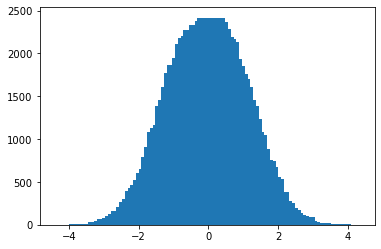

In [91]:
import matplotlib.pyplot as plt

content, edges = histograms["hpx"].numpy()

plt.bar(edges[:-1], content)

But there are projects in Scikit-HEP that are seeking to address that (another shout-out).

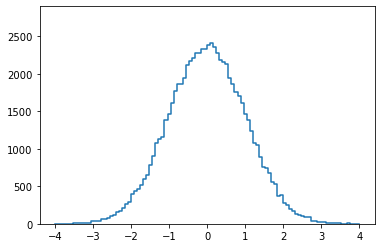

In [92]:
import mplhep as hep

hep.histplot(histograms["hpx"].numpy())

Text(0.5, 24.0, "b'py vs px'")

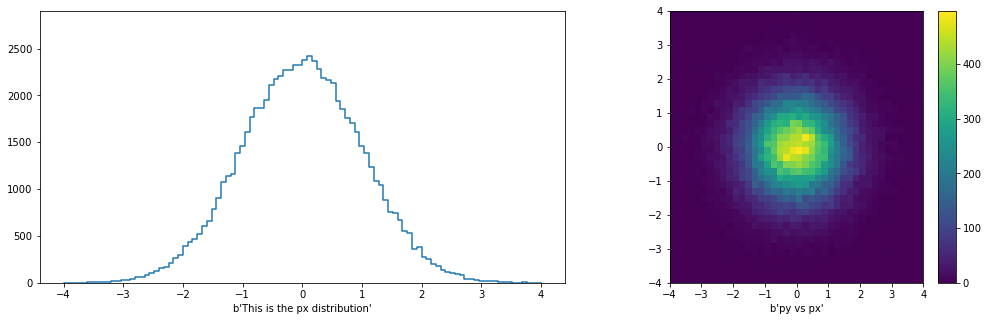

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

hep.histplot(histograms["hpx"].numpy(), ax=ax1)
ax1.set_xlabel(histograms["hpx"].title)

content, ((xbins, ybins),) = histograms["hpxpy"].numpy()
hep.hist2dplot(content, xbins, ybins, ax=ax2)
ax2.set_xlabel(histograms["hpxpy"].title)

For histogramming, take a look at the following. With the exception of `hist` (a new project in Scikit-HEP), they are all complete, stable, and actively maintained.

   * [Boost.Histogram](https://www.boost.org/doc/libs/1_73_0/libs/histogram/doc/html/index.html): minimal-dependencies, fast-filling, flexible, HEP-style histograms in C++, which has been accepted into Boost.
   * [boost-histogram](https://github.com/scikit-hep/boost-histogram): Python bindings for Boost.Histogram.
   * [mplhep](https://github.com/scikit-hep/mplhep): plotting interface over Matplotlib, providing CMS and ATLAS styles and other HEP conveniences.
   * [histoprint](https://github.com/ast0815/histoprint): histogram renderer for terminals and command-lines.
   * [Physt](https://github.com/janpipek/physt): complete histogramming package with a HEP-like point of view.
   * [hist](https://github.com/scikit-hep/hist): Pythonic "one-stop-shop" for histogramming, pulling in all dependencies to make plotting easier. Filling via boost-histogram, plotting via mplhep, text output via histoprint.
   * [Coffea histograms](https://coffeateam.github.io/coffea/notebooks/histograms.html): intended as an intermediate, presages some of the features of hist.

Of course there's also [PyROOT](https://root.cern.ch/pyroot) and [rootpy](https://pypi.org/project/rootpy). If you're a theorist, you've probably heard of [YODA](https://yoda.hepforge.org/pydoc).

But there's many others, too: [fast-histogram](https://pypi.org/project/fast-histogram), [qhist](https://pypi.org/project/qhist), [hdrhistogram](https://pypi.python.org/pypi/hdrhistogram), [multihist](https://pypi.python.org/pypi/multihist), [matplotlib-hep](https://github.com/ibab/matplotlib-hep), [pyhistogram](https://pypi.python.org/pypi/pyhistogram), [histogram](https://pypi.python.org/pypi/histogram), [SimpleHist](https://pypi.python.org/pypi/SimpleHist), [paida](https://pypi.org/project/paida), [histogramy](https://pypi.python.org/pypi/histogramy), [pypeaks](https://pypi.python.org/pypi/pypeaks), [hierogram](https://pypi.python.org/pypi/hierogram), [histo](https://pypi.python.org/pypi/histo), [python-metrics](https://pypi.python.org/pypi/python-metrics), [statscounter](https://pypi.python.org/pypi/statscounter), [datagram](https://pypi.python.org/pypi/datagram), [histogram](https://github.com/theodoregoetz/histogram) and [dashi](http://www.ifh.de/~middell/dashi/index.html), most of which seem to have been abandoned.

That's not even counting the six I've written: [plothon](http://code.google.com/p/plothon), [svgfig](http://code.google.com/p/svgfig), [cassius](https://github.com/opendatagroup/cassius), [histogrammar](https://github.com/histogrammar), [histbook](https://github.com/scikit-hep/histbook), and [aghast](https://github.com/scikit-hep/aghast) (though this last one is a middleware tool, not user-facing).

**Moral:** starting a histogram package is easy, growing a community around one so that it develops is hard.

Uproot's histogram functionality will defer more to 

## Active objects from TTrees

Above, you've seen how we could extract auto-generated `Event` objects from a TTree, as well as auto-generated histograms from a TDirectory.

Can objects from a TTree have methods?

**Yes!** In fact, they can be histograms. (Thanks to Cédric Hernalsteens for supplying this example in [Uproot issue #399](https://github.com/scikit-hep/uproot/issues/399).)

In [108]:
array_of_histograms = uproot.open("data/issue399.root")["Event/Histos.histograms1D"].array()
array_of_histograms

<ObjectArray [[<b'TH1D' b'PhitsHisto' 0x7f0d847480b0>, <b'TH1D' b'PlossHisto' 0x7f0d84748350>, <b'TH1D' b'ElossHisto' 0x7f0d847485f0>, <b'TH1D' b'PhitsPEHisto' 0x7f0d84748890>, <b'TH1D' b'PlossPEHisto' 0x7f0d84748b30>, <b'TH1D' b'ElossPEHisto' 0x7f0d84748dd0>] [<b'TH1D' b'PhitsHisto' 0x7f0d847370b0>, <b'TH1D' b'PlossHisto' 0x7f0d84737350>, <b'TH1D' b'ElossHisto' 0x7f0d847375f0>, <b'TH1D' b'PhitsPEHisto' 0x7f0d84737890>, <b'TH1D' b'PlossPEHisto' 0x7f0d84737b30>, <b'TH1D' b'ElossPEHisto' 0x7f0d84737dd0>] [<b'TH1D' b'PhitsHisto' 0x7f0d84737050>, <b'TH1D' b'PlossHisto' 0x7f0d84748110>, <b'TH1D' b'ElossHisto' 0x7f0d847483b0>, <b'TH1D' b'PhitsPEHisto' 0x7f0d84748650>, <b'TH1D' b'PlossPEHisto' 0x7f0d847488f0>, <b'TH1D' b'ElossPEHisto' 0x7f0d84748b90>] ... [<b'TH1D' b'PhitsHisto' 0x7f0d84748170>, <b'TH1D' b'PlossHisto' 0x7f0d84748410>, <b'TH1D' b'ElossHisto' 0x7f0d847486b0>, <b'TH1D' b'PhitsPEHisto' 0x7f0d84748950>, <b'TH1D' b'PlossPEHisto' 0x7f0d84748bf0>, <b'TH1D' b'ElossPEHisto' 0x7f0d84748

(In fact, the issue was that these are _lists_ of histograms in each TTree entry.)

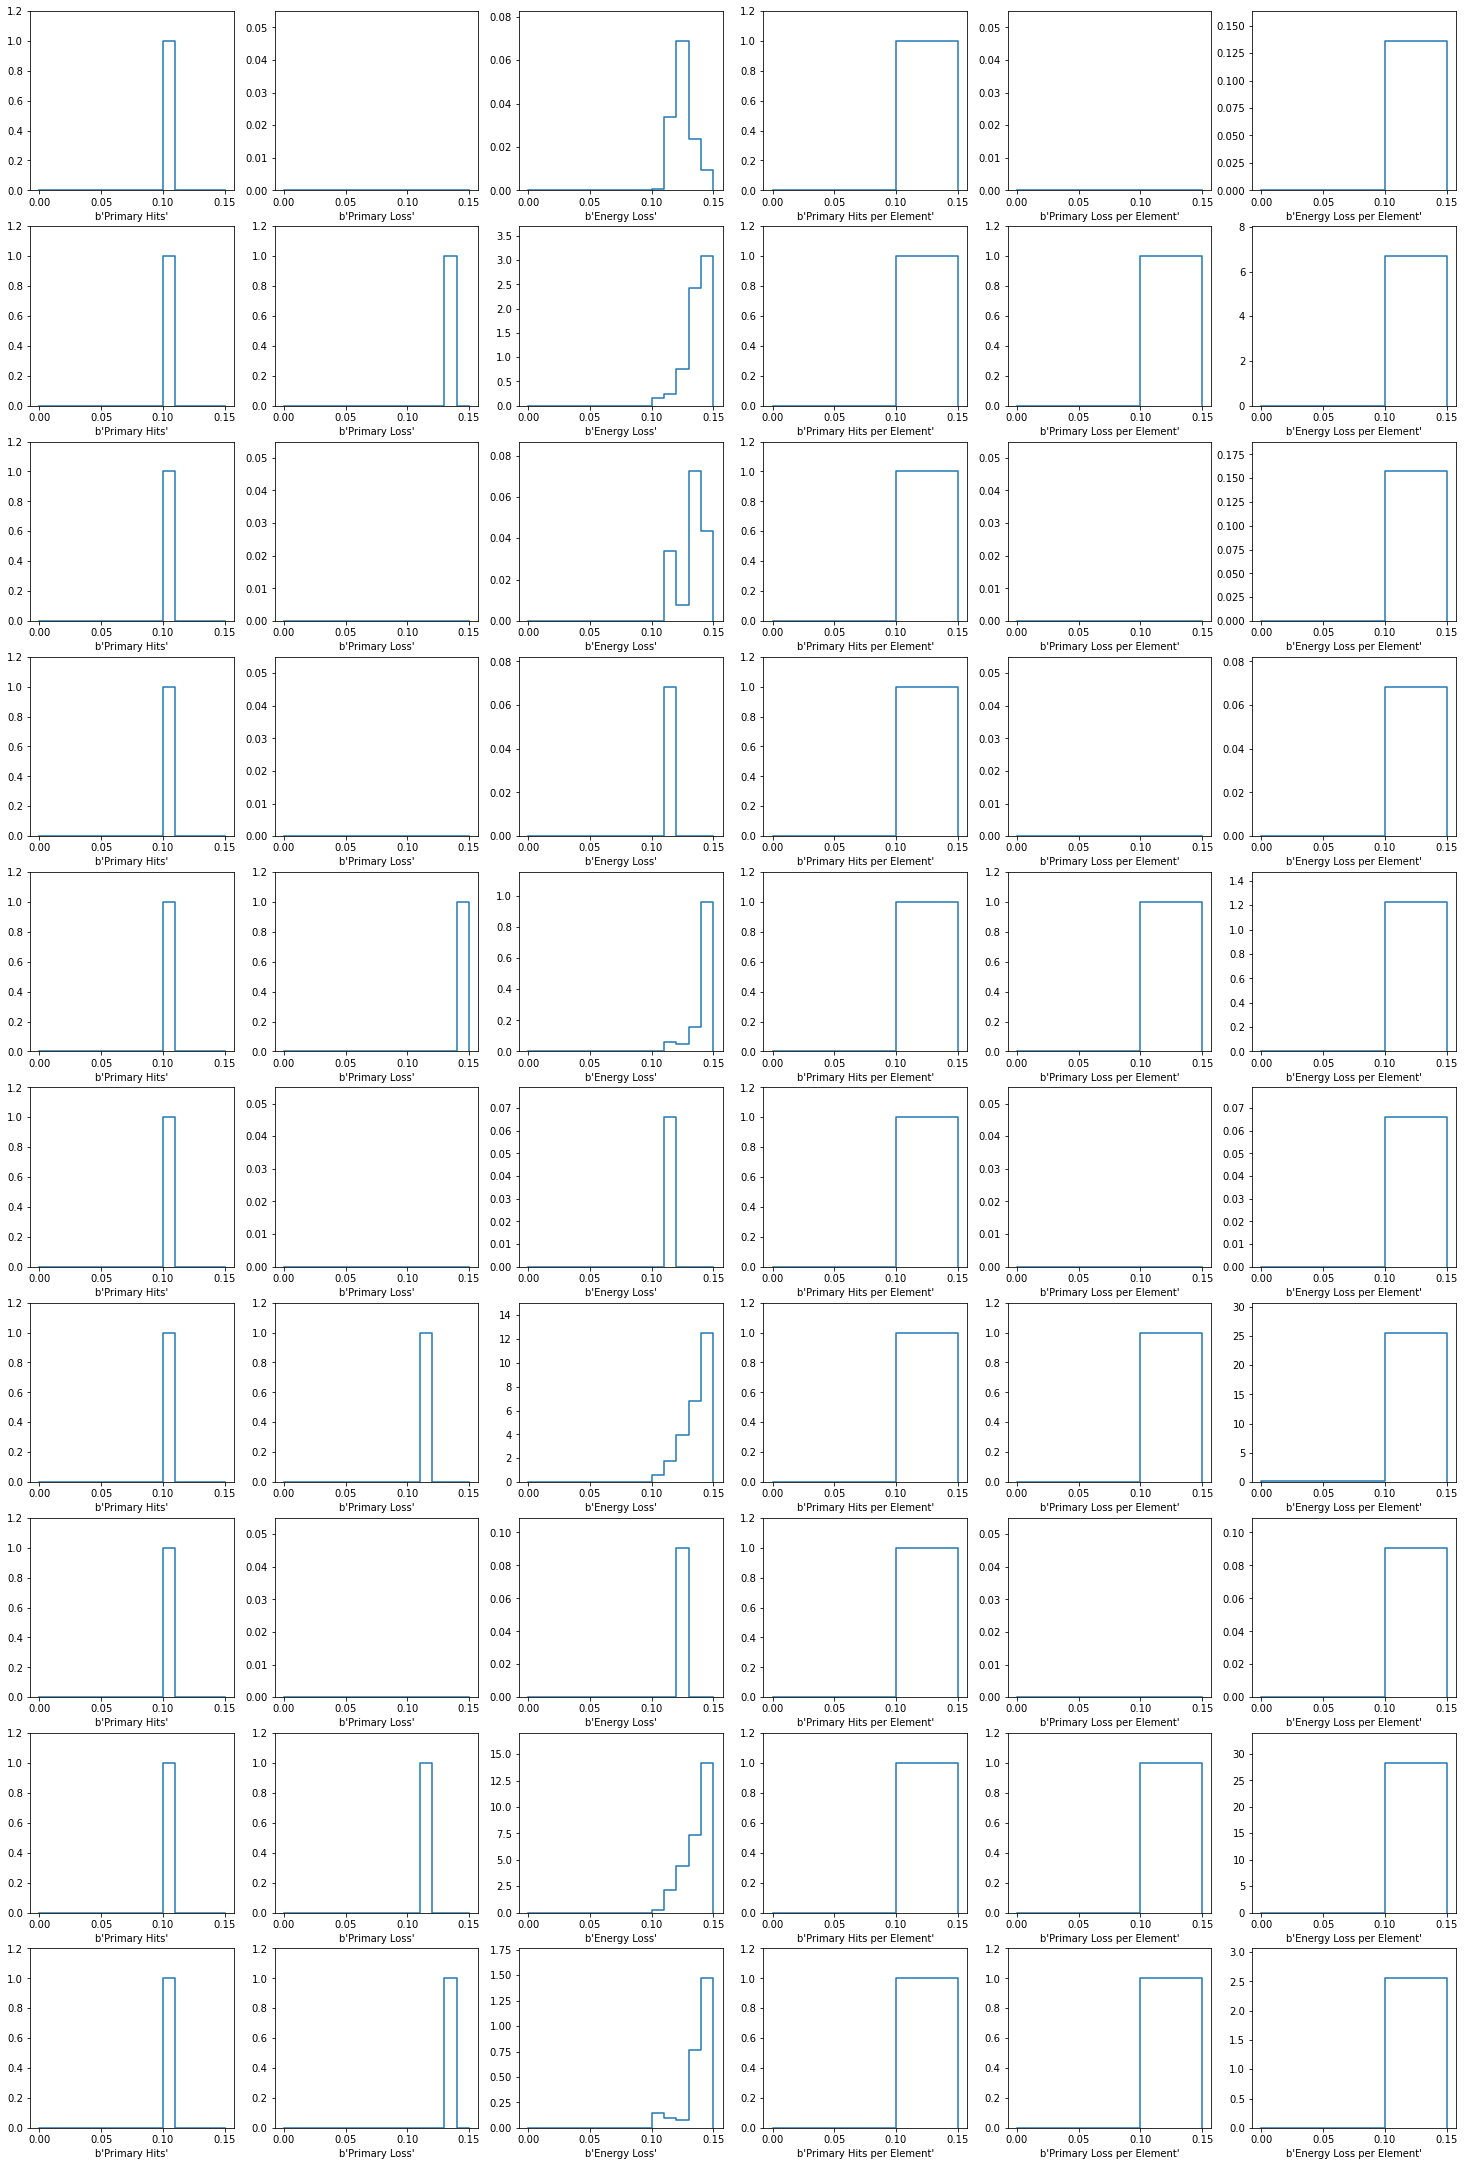

In [126]:
fig, axes = plt.subplots(10, 6, figsize=(18, 30))
fig.subplots_adjust(bottom=-0.1, left=-0.2)

i, j = 0, 0
for hists in array_of_histograms:
    for hist in hists:
        hep.histplot(hist.numpy(), ax=axes[i][j])
        axes[i][j].set_xlabel(hist.title)
        j += 1
        if j == 6:
            i += 1
            j = 0

## Lorentz vectors

Perhaps the most important active objects are Lorentz vectors.

In [130]:
without_lorentz = uproot.open("data/HZZ.root")["events"]
with_lorentz = uproot.open("data/HZZ-objects.root")["events"]

In [131]:
without_lorentz.show()

NJet                       (no streamer)              asdtype('>i4')
Jet_Px                     (no streamer)              asjagged(asdtype('>f4'))
Jet_Py                     (no streamer)              asjagged(asdtype('>f4'))
Jet_Pz                     (no streamer)              asjagged(asdtype('>f4'))
Jet_E                      (no streamer)              asjagged(asdtype('>f4'))
Jet_btag                   (no streamer)              asjagged(asdtype('>f4'))
Jet_ID                     (no streamer)              asjagged(asdtype('bool'))
NMuon                      (no streamer)              asdtype('>i4')
Muon_Px                    (no streamer)              asjagged(asdtype('>f4'))
Muon_Py                    (no streamer)              asjagged(asdtype('>f4'))
Muon_Pz                    (no streamer)              asjagged(asdtype('>f4'))
Muon_E                     (no streamer)              asjagged(asdtype('>f4'))
Muon_Charge                (no streamer)              asjagged(asdtype(

In [132]:
with_lorentz.show()

jetp4                      TStreamerSTL               asjagged(asobj(<uproot_methods.classes.TLorentzVector.Methods>), 10)
jetbtag                    TStreamerSTL               asjagged(asdtype('>f4'), 10)
jetid                      TStreamerSTL               asjagged(asdtype('bool'), 10)
muonp4                     TStreamerSTL               asjagged(asobj(<uproot_methods.classes.TLorentzVector.Methods>), 10)
muonq                      TStreamerSTL               asjagged(asdtype('>i4'), 10)
muoniso                    TStreamerSTL               asjagged(asdtype('>f4'), 10)
electronp4                 TStreamerSTL               asjagged(asobj(<uproot_methods.classes.TLorentzVector.Methods>), 10)
electronq                  TStreamerSTL               asjagged(asdtype('>i4'), 10)
electroniso                TStreamerSTL               asjagged(asdtype('>f4'), 10)
photonp4                   TStreamerSTL               asjagged(asobj(<uproot_methods.classes.TLorentzVector.Methods>), 10)
photoniso